<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>Brownian Translational diffusion</b> model to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 AA$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

### Physical units
Please note that the following units are used for the QENS models

| Type of parameter | Unit          |
| ----------------- |---------------|
| Time              | picosecond    |
| Length            | Angstrom      |
| Momentum transfer | 1/Angstrom    |

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps

# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

In [3]:
# install QENSmodels (if not already installed)

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [4]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   


# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, D=0.1, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.D.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D  
    else:
        Mq.D = QD
    M.append(Mq)
        
problem = FitProblem(M)

<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description='Minimizer:', options={'Levenberg-Marquardt': 'lm', 'Nelder-Mead Simplex': 'amoeba', 'DRE…

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 502.4650(59)


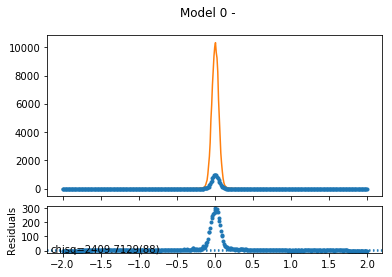

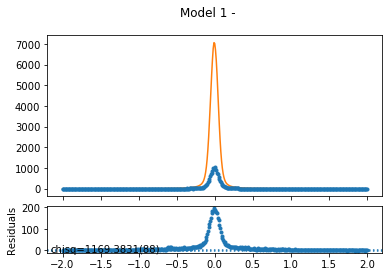

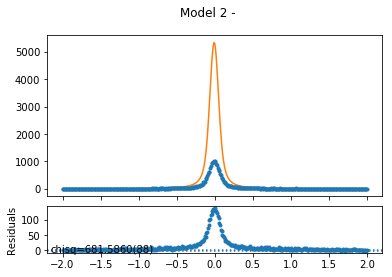

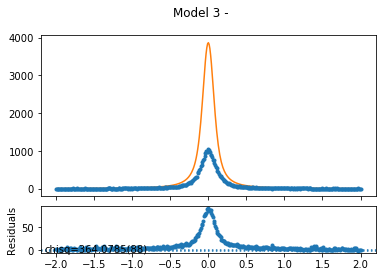

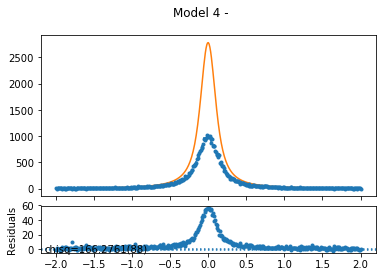

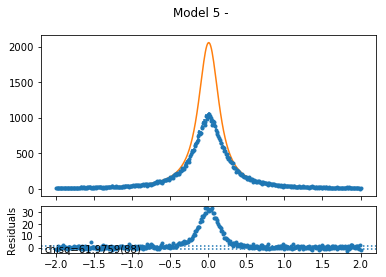

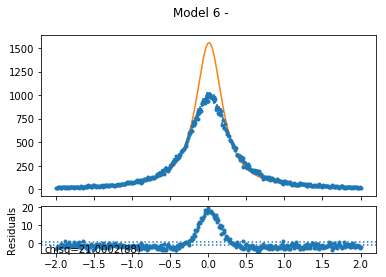

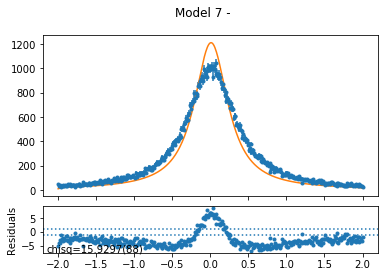

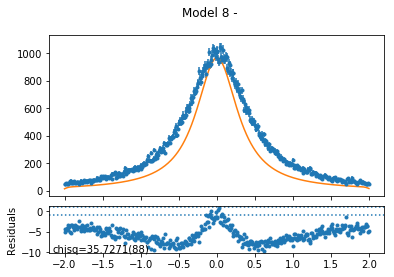

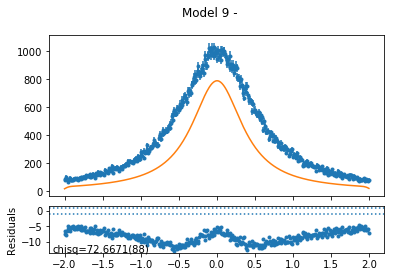

In [7]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [8]:
result = fit(problem, 
             method=w_choice_minimizer.value, 
             steps=steps, 
             verbose=True)

final chisq 0.9996(59)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                       D 0.14413(29)     0.14413(29)    
                                  center -0.48(55)e-3    -0.48(55)e-3   
                                   scale 110.9(12)       110.9(12)      
                                  center 0.35(55)e-3     0.35(55)e-3    
                                   scale 155.0(13)       155.0(13)      
                                  center -0.95(67)e-3    -0.95(67)e-3   
                                   scale 229.0(15)       229.0(15)      
                                  center -0.31(90)e-3    -0.31(90)e-3   
                                   scale 332.6(19)       332.6(19)      
                                  center 0.1(11)e-3      0.1(11)e-3     
                                   scale 484.2(23)       484.2(23)      
                                  center 0.7(11)e-3      0.7(11)e-3     
                         

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

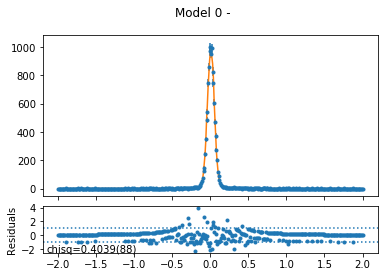

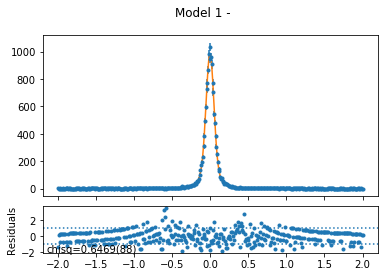

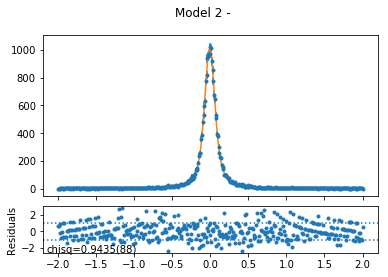

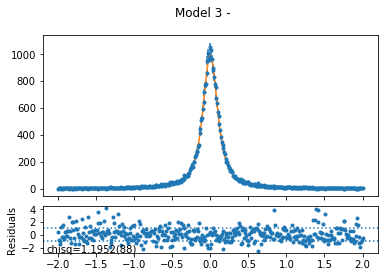

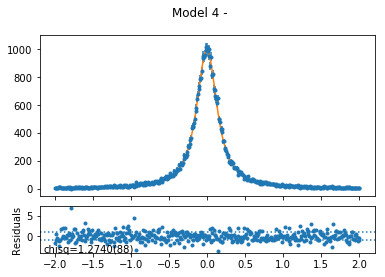

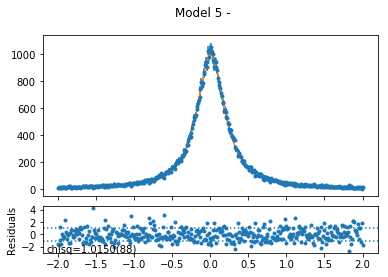

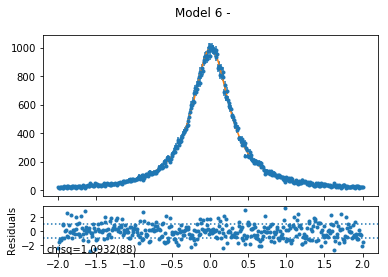

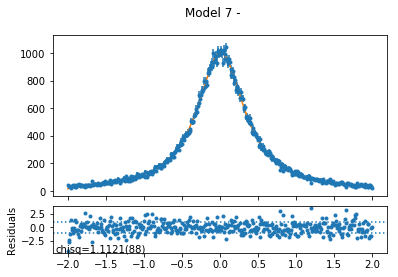

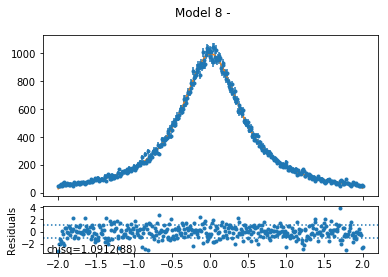

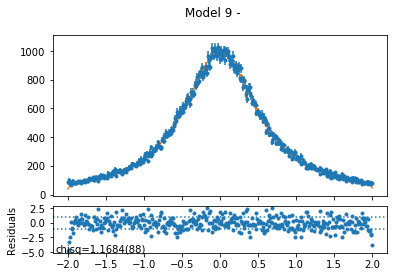

In [9]:
problem.plot()

In [10]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 0.9996(59)
D : 0.14413(29)
center : -0.48(55)e-3
scale : 110.9(12)
center : 0.35(55)e-3
scale : 155.0(13)
center : -0.95(67)e-3
scale : 229.0(15)
center : -0.31(90)e-3
scale : 332.6(19)
center : 0.1(11)e-3
scale : 484.2(23)
center : 0.7(11)e-3
scale : 676.6(27)
center : -2.2(13)e-3
scale : 904.5(32)
center : 0.04(79)e-3
scale : 1176.0(37)
center : 0.6(15)e-3
scale : 1475.4(42)
center : -1.1(19)e-3
scale : 1823.9(48)
